In [1]:
!pip install bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import os
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple, Optional
from dataclasses import dataclass
import torch # Import torch AFTER bitsandbytes and accelerate
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, Dataset as HFDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    set_seed,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_kbit_training,
    PeftModel, # Import PeftModel
    PeftConfig
)
import logging
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, util
import requests
import xml.etree.ElementTree as ET
import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
class ProjectConfig:
    model_name: str = "tiiuae/falcon-7b"
    max_length: int = 128
    batch_size: int = 1
    num_epochs: int = 2
    learning_rate: float = 2e-5
    weight_decay: float = 0.001
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.05
    output_dir: str = "/content/drive/MyDrive/Model/"
    eval_steps: int = 100
    save_steps: int = 100
    label_map: Dict[str, int] = None
    num_labels: int = 3

# Initialize with proper label mapping
config = ProjectConfig()
config.label_map = {"TRUE": 0, "True": 0, "real": 0,
                    "FALSE": 1, "False": 1, "fake": 1,
                    "MISLEADING": 2, "Misleading": 2, "misleading": 2}

In [4]:
import traceback
from datasets import Dataset as HFDataset

# Configure logging
logger = logging.getLogger(__name__)
if not logger.handlers:
    logging.basicConfig(level=logging.INFO)

class MedicalDataPreprocessor:
    """Configuration class for the project"""
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {
        "TRUE": 0, "True": 0, "real": 0, True: 0,
        "FALSE": 1, "False": 1, "fake": 1, False: 1,
        "MISLEADING": 2, "Misleading": 2, "misleading": 2
    }  # Should be defined by the config

    # Create output directory for analysis results

    def load_healthfact(self):
        os.makedirs('/content/results/dataset_final', exist_ok=True)

        print("Analyzing HealthFact dataset...")

        train_path = '/content/drive/MyDrive/Health fact Cleaned Datasets/Health fact Cleaned Datasets/HealthFact_traindata_.csv'
        dev_path = '/content/drive/MyDrive/Health fact Cleaned Datasets/Health fact Cleaned Datasets/Cleaned_dev_Dataset.csv'
        test_path = '/content/drive/MyDrive/Health fact Cleaned Datasets/Health fact Cleaned Datasets/Cleaned_Test_Dataset.csv'

        train_df = pd.read_csv(train_path)
        dev_df = pd.read_csv(dev_path)
        test_df = pd.read_csv(test_path)

        train_df = train_df.rename(columns={'claim': 'text', 'explanation': 'evidence'})
        dev_df = dev_df.rename(columns={'claim': 'text', 'explanation': 'evidence'})
        test_df = test_df.rename(columns={'claim': 'text', 'explanation': 'evidence'})

        # Standardize labels
        label_map = {
            'true': 'TRUE',
            'false': 'FALSE',
            'MISLEADING': 'MISLEADING',
            'misleading': 'MISLEADING'
        }

        train_df['label'] = train_df['label'].map(label_map)
        dev_df['label'] = dev_df['label'].map(label_map)
        test_df['label'] = test_df['label'].map(label_map)

        # Select relevant columns
        train_df = train_df[['text', 'evidence', 'label']]
        dev_df = dev_df[['text', 'evidence', 'label']]
        test_df = test_df[['text', 'evidence', 'label']]

        return train_df, dev_df, test_df

    def load_scifact(self):
        print("\nAnalyzing SciFact dataset...")

        train_path = '/content/drive/MyDrive/scifact/cleaned_datasets/train_3class.jsonl'
        dev_path = '/content/drive/MyDrive/scifact/cleaned_datasets/dev_3class.jsonl'
        test_path = '/content/drive/MyDrive/scifact/cleaned_datasets/claims_test.jsonl'

        def load_jsonl(path):
            with open(path, 'r') as f:
                return [json.loads(line) for line in f]

        train_df = pd.DataFrame(load_jsonl(train_path))
        dev_df = pd.DataFrame(load_jsonl(dev_path))
        test_df = pd.DataFrame(load_jsonl(test_path))

        # Test set does not have labels
        try:
            test_data = []
            with open(test_path, 'r') as f:
                for line in f:
                    test_data.append(json.loads(line))
            test_df = pd.DataFrame(test_data)
            if 'label' not in test_df.columns:
                print("SciFact test set doesn't have labels. Using a portion of dev set as test set.")
                # Split dev set into dev and test
                dev_df, test_df = train_test_split(dev_df, test_size=0.5, random_state=42, stratify=dev_df['label'])
        except:
            print("Error loading SciFact test set. Using a portion of dev set as test set.")
            # Split dev set into dev and test
            dev_df, test_df = train_test_split(dev_df, test_size=0.5, random_state=42, stratify=dev_df['label'])

        # Standardize column names
        if 'claim' in train_df.columns:
            train_df = train_df.rename(columns={'claim': 'text', 'evidence_text': 'evidence'})
        if 'claim' in dev_df.columns:
            dev_df = dev_df.rename(columns={'claim': 'text', 'evidence_text': 'evidence'})
        if 'claim' in test_df.columns:
            test_df = test_df.rename(columns={'claim': 'text', 'evidence_text': 'evidence'})

        # Standardize labels
        label_map = {
            'True': 'TRUE',
            'False': 'FALSE',
            'Misleading': 'MISLEADING',
            'SUPPORTS': 'TRUE',
            'REFUTES': 'FALSE',
            'NOT_ENOUGH_INFO': 'MISLEADING'
        }

        if 'label' in train_df.columns:
            train_df['label'] = train_df['label'].map(label_map)
        if 'label' in dev_df.columns:
            dev_df['label'] = dev_df['label'].map(label_map)
        if 'label' in test_df.columns:
            test_df['label'] = test_df['label'].map(label_map)

        # Ensure all required columns exist
        for df in [train_df, dev_df, test_df]:
            if 'evidence' not in df.columns:
                df['evidence'] = ''

        # Select relevant columns
        train_df = train_df[['text', 'evidence', 'label']]
        dev_df = dev_df[['text', 'evidence', 'label']]
        test_df = test_df[['text', 'evidence', 'label']]

        return train_df, dev_df, test_df

    def load_covid_fake_news(self):
        print("\nAnalyzing COVID-19 Fake News dataset...")

        train_path = '/content/drive/MyDrive/Covid-19 Cleaned Datasets/Covid-19 Cleaned Datasets/data/Cleaned_Covid19_Train.csv'
        dev_path = '/content/drive/MyDrive/Covid-19 Cleaned Datasets/Covid-19 Cleaned Datasets/data/Cleaned_Covid19_Dev.csv'
        test_path = '/content/drive/MyDrive/Covid-19 Cleaned Datasets/Covid-19 Cleaned Datasets/data/Cleaned_Covid19_Test.csv'

        train_df = pd.read_csv(train_path)
        dev_df = pd.read_csv(dev_path)
        test_df = pd.read_csv(test_path)

        # Standardize column names
        train_df = train_df.rename(columns={'tweet': 'text'})
        dev_df = dev_df.rename(columns={'tweet': 'text'})
        test_df = test_df.rename(columns={'tweet': 'text'})

        def clean_labels(df):
            # Handle various label formats
            df['label'] = df['label'].astype(str).str.strip().str.upper()

            # Map different label variations
            label_map = {
                'REAL': 'TRUE',
                'TRUE': 'TRUE',
                'FAKE': 'FALSE',
                'FALSE': 'FALSE',
                '0': 'TRUE',  # Handle numeric labels
                '1': 'FALSE',
                'NAN': np.nan  # Explicitly handle NaN strings
            }

            df['label'] = df['label'].map(label_map)

            # Convert boolean-like strings
            df['label'] = df['label'].replace({
                'TRUE': 'TRUE',
                'FALSE': 'FALSE'
            })

            # Drop rows with invalid labels
            valid_labels = ['TRUE', 'FALSE']
            initial_count = len(df)
            df = df.dropna(subset=['label'])
            df = df[df['label'].isin(valid_labels)]
            final_count = len(df)

            if initial_count != final_count:
                print(f"Removed {initial_count - final_count} invalid entries")

            return df

        # Process all datasets
        train_df = clean_labels(train_df)
        dev_df = clean_labels(dev_df)
        test_df = clean_labels(test_df)

        # Add evidence column
        for df in [train_df, dev_df, test_df]:
            df['evidence'] = ''

        # Select relevant columns
        cols = ['text', 'evidence', 'label']
        return (
            train_df[cols].reset_index(drop=True),
            dev_df[cols].reset_index(drop=True),
            test_df[cols].reset_index(drop=True)
        )

    def balance_dataset(self, data):
        """Balance dataset to prevent bias toward any label"""
        # Group by labels
        label_groups = {}
        for item in data:
            label = item["label"]
            if label not in label_groups:
                label_groups[label] = []
            label_groups[label].append(item)

        # Find minimum count across labels
        min_count = min(len(group) for group in label_groups.values())

        balanced_data = []
        for label, group in label_groups.items():
            if len(group) > min_count:
                # Random subsample
                sampled_indices = np.random.choice(len(group), min_count, replace=False)
                balanced_data.extend([group[i] for i in sampled_indices])
            else:
                balanced_data.extend(group)

        logger.info(f"Balanced dataset: {len(balanced_data)} examples, {min_count} per class")
        return balanced_data

    def prepare_for_training(self, data):
        """Convert processed data into HuggingFace dataset format"""
        # Prepare training features
        features = []
        skipped_count = 0

        # Ensure label_map from config is available
        if self.label_map is None:
            raise ValueError("label_map from config is not set in MedicalDataPreprocessor.")

        for item in data:
            # Format input text
            if item["evidence"]:
                text = f"Claim: {item['text']}\nEvidence: {item['evidence']}"
            else:
                text = f"Claim: {item['text']}"

            # Tokenize
            encoding = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )

            # Add label - map string label to integer ID
            string_label = item["label"]
            if string_label not in self.label_map:
                # Handle potential unknown labels if necessary, e.g., skip or assign a default
                logger.warning(f"Unknown label '{string_label}' encountered. Skipping item.")
                skipped_count += 1
                continue # Skip this item

            label_id = self.label_map[string_label]
            encoding["labels"] = label_id # Assign integer label ID

            features.append(encoding)

        if skipped_count > 0:
            logger.warning(f"Skipped {skipped_count} items due to unknown labels")

        if not features:
            logger.error("No valid features created! Check your data and label mappings.")
            return None

        # Convert to HuggingFace Dataset
        dataset_dict = {
            "input_ids": torch.cat([f["input_ids"] for f in features]),
            "attention_mask": torch.cat([f["attention_mask"] for f in features]),
            # Use integer labels directly
            "labels": torch.tensor([f["labels"] for f in features])
        }

        return HFDataset.from_dict(dataset_dict)

    def process_datasets(self):
        """Process all datasets and prepare for model training"""


        healthfact_train_data, healthfact_dev_data, healthfact_test_data = self.load_healthfact()

        # Load SciFact dataset
        scifact_train_data, scifact_dev_data, scifact_test_data = self.load_scifact()

        # Load COVID-19 Fake News dataset
        covid_train_data, covid_dev_data, covid_test_data = self.load_covid_fake_news()

        # For the first stage we pre-train on healthfact + scifact
        # Combine HealthFact train data with SciFact data for pretraining
        pretrain_train_data = pd.concat([healthfact_train_data, scifact_train_data], ignore_index=True)
        pretrain_eval_data = pd.concat([healthfact_dev_data, scifact_dev_data], ignore_index=True)
        pretrain_test_data = pd.concat([healthfact_test_data, scifact_test_data], ignore_index=True)


        # Then we fine-tune on COVID-19 data
        finetune_train_data = covid_train_data
        finetune_eval_data = covid_dev_data
        finetune_test_data = covid_test_data

        pretrain_train_data = pretrain_train_data.to_dict('records')
        pretrain_eval_data = pretrain_eval_data.to_dict('records')
        pretrain_test_data = pretrain_test_data.to_dict('records')

        finetune_train_data = finetune_train_data.to_dict('records')
        finetune_eval_data = finetune_eval_data.to_dict('records')
        finetune_test_data = finetune_test_data.to_dict('records')

        pretrain_train_data = self.balance_dataset(pretrain_train_data)
        finetune_train_data = self.balance_dataset(finetune_train_data)

        # Prepare datasets for model
        pretrain_train_dataset = self.prepare_for_training(pretrain_train_data)
        pretrain_eval_dataset = self.prepare_for_training(pretrain_eval_data)
        pretrain_test_dataset = self.prepare_for_training(pretrain_test_data)

        finetune_train_dataset = self.prepare_for_training(finetune_train_data)
        finetune_eval_dataset = self.prepare_for_training(finetune_eval_data)
        finetune_test_dataset = self.prepare_for_training(finetune_test_data)

        return {
            "pretrain": {
                "train": pretrain_train_dataset,
                "eval": pretrain_eval_dataset,
                "test": pretrain_test_dataset
            },
            "finetune": {
                "train": finetune_train_dataset,
                "eval": finetune_eval_dataset,
                "test": finetune_test_dataset
            }
        }

In [5]:
class ModelTrainer:
    """Handles model training with LoRA for efficiency"""

    def __init__(self, model_name, num_labels=None):
        self.model_name = model_name
        self.config = config
        # Use num_labels from config
        self.num_labels = num_labels if num_labels is not None else config.num_labels

        # check for PEFT adapter
        is_peft_adapter = os.path.exists(os.path.join(model_name, "adapter_config.json")) or os.path.exists(os.path.join(model_name, "adapter.json"))

        if is_peft_adapter:
            # PEFT/LoRA adapter path
            print(f"Loading PEFT adapter from {model_name}")

            # Load the tokenizer first from the saved path including added tokens
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right", trust_remote_code=True)
            print(f"Loaded tokenizer from saved path: {len(self.tokenizer)} vocabulary size")

            # Load the base model using the original model name from config
            base_model_name = config.model_name
            print(f"Loading base model from {base_model_name}")
            base_model = AutoModelForSequenceClassification.from_pretrained(
                base_model_name,
                num_labels=self.num_labels,
                trust_remote_code=True,
                torch_dtype=torch.bfloat16,
                device_map="auto"
            )

            base_model.resize_token_embeddings(len(self.tokenizer))
            print(f"Resized base model embeddings to match tokenizer: {base_model.get_input_embeddings().weight.size(0)}")


            # Load the PEFT adapter weights onto the resized base model
            self.model = PeftModel.from_pretrained(base_model, model_name)
            print(f"Successfully loaded base model {base_model_name} and applied adapter from {model_name}")
        else:
            print(f"Loading regular model from {model_name}")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right", trust_remote_code=True)
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name,
                num_labels=self.num_labels,
                trust_remote_code=True,
                torch_dtype=torch.bfloat16, # Use bfloat16
                device_map="auto" # Use device_map
            )
        # Special tokens if in case missing
        special_tokens = {"pad_token": "[PAD]"}
        if self.tokenizer.pad_token is None:
            print(f"Adding {special_tokens['pad_token']} to tokenizer.")
            self.tokenizer.add_special_tokens(special_tokens)
            if not is_peft_adapter or self.model.get_input_embeddings().weight.size(0) != len(self.tokenizer):
                 print("Resizing model embeddings after adding special tokens.")
                 self.model.resize_token_embeddings(len(self.tokenizer))
                 print(f"New model embedding size: {self.model.get_input_embeddings().weight.size(0)}")
            self.tokenizer.pad_token = '[PAD]' # Ensure pad_token is set


        print(f"Final loaded tokenizer and model for {model_name}")
        print(f"Model dtype: {self.model.dtype}")
        print(f"Model device: {self.model.device}")

    def setup_model(self):
        """Initialize model with LoRA configuration"""
        from google.colab import userdata
        userdata.get('LLMs')
        # Quantization
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, # Load in 8-bit
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )

        # Load base model
        model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels,
            torch_dtype=torch.bfloat16,
            quantization_config=bnb_config,
            device_map="auto"
        )

        # Resize token embeddings in case we added special tokens
        model.resize_token_embeddings(len(self.tokenizer))

        # Prepare model for LoRA fine-tuning
        model = prepare_model_for_kbit_training(model)

        # LoRA configuration
        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=self.config.lora_r,
            lora_alpha=self.config.lora_alpha,
            lora_dropout=self.config.lora_dropout,
            bias="none",
            target_modules=["query_key_value"],
        )

        # Get PEFT model
        model = get_peft_model(model, peft_config)
        logger.info(f"Model set up with LoRA fine-tuning configuration")

        return model

    def evaluate(self, test_dataset):
        """Evaluate the model on a test dataset"""
        # Setup training arguments for evaluation only
        eval_args = TrainingArguments(
            output_dir="./eval_tmp",
            per_device_eval_batch_size=self.config.batch_size,
            bf16=True,
        )

        # Define compute metrics function (same as in train)
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average='weighted'
            )

            # Calculate false positive rate for true statements
            true_indices = (labels == 0)  # True class
            fps_for_true = (predictions[true_indices] != 0).sum() / max(1, len(true_indices))

            # Convert logits to probabilities
            probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

            # One-vs-rest ROC-AUC for each class
            auc_scores = []
            for i in range(self.num_labels):
                # Create binary labels for this class
                binary_labels = (labels == i).astype(int)
                try:
                    auc = roc_auc_score(binary_labels, probs[:, i])
                    auc_scores.append(auc)
                except:
                    auc_scores.append(0.5)  # Default when calculation fails

            return {
                "accuracy": accuracy_score(labels, predictions),
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "false_positive_rate_for_true": float(fps_for_true),
                "roc_auc_avg": np.mean(auc_scores)
            }

        # Create trainer for evaluation
        eval_trainer = Trainer(
            model=self.model,
            args=eval_args,
            compute_metrics=compute_metrics
        )

        # Return evaluation results
        return eval_trainer.evaluate(test_dataset)

    def train(self, train_dataset, eval_dataset, output_dir, num_epochs=None, use_existing_model=False):
        """Train the model with the provided datasets"""
        if num_epochs is None:
            num_epochs = self.config.num_epochs

        # Use existing model or set up new one
        if use_existing_model and hasattr(self, 'model'):
            model = self.model
            print("Using existing model for continued training")
        else:
            model = self.setup_model()
            print("Setting up new model from scratch")
        # Training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            eval_strategy="steps",
            eval_steps=self.config.eval_steps,
            save_strategy="steps",
            save_steps=self.config.save_steps,
            learning_rate=self.config.learning_rate,
            per_device_train_batch_size=self.config.batch_size,
            per_device_eval_batch_size=self.config.batch_size,
            num_train_epochs=num_epochs,
            weight_decay=self.config.weight_decay,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            push_to_hub=False,
            logging_dir=os.path.join(output_dir, "logs"),
            logging_steps=100,
            bf16=True,
            gradient_accumulation_steps=8,
        )

        # Compute metrics function
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average='weighted'
            )

            # Calculate false positive rate for true statements
            # Calculate per-class metrics
            true_indices = (labels == 0)  # True class
            fps_for_true = (predictions[true_indices] != 0).sum() / max(1, len(true_indices))

            # Convert logits to probabilities for ROC-AUC
            probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

            # One-vs-rest ROC-AUC for each class
            auc_scores = []
            for i in range(self.num_labels):
                # Create binary labels for this class
                binary_labels = (labels == i).astype(int)
                try:
                    auc = roc_auc_score(binary_labels, probs[:, i])
                    auc_scores.append(auc)
                except:
                    auc_scores.append(0.5)  # Default when calculation fails

            return {
                "accuracy": accuracy_score(labels, predictions),
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "false_positive_rate_for_true": float(fps_for_true),
                "roc_auc_avg": np.mean(auc_scores)
            }

        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=compute_metrics,
            label_names=["labels"],
            callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
        )

        # Train the model
        logger.info("Starting model training...")
        trainer.train()

        # Save the best model
        trainer.save_model(os.path.join(output_dir, "best_model"))
        self.tokenizer.save_pretrained(os.path.join(output_dir, "best_model"))

        logger.info(f"Model training completed and saved to {output_dir}/best_model")
        return trainer


In [6]:
class RAGConfidenceScorer:
    """Implements confidence scoring using RAG from PubMed"""

    def __init__(self, model_path=None, model=None, tokenizer=None):
        self.sentence_encoder = SentenceTransformer('all-MiniLM-L6-v2')

        if model is not None and tokenizer is not None:
            self.model = model
            self.tokenizer = tokenizer
            logger.info("Using provided model and tokenizer for RAGConfidenceScorer.")
        elif model_path:
            logger.info(f"Loading model from {model_path} for RAGConfidenceScorer.")
            try:
                num_labels = 3
                self.tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="right", trust_remote_code=True)
                self.model = AutoModelForSequenceClassification.from_pretrained(
                    model_path,
                    num_labels=num_labels,
                    trust_remote_code=True,
                    torch_dtype=torch.bfloat16,
                    device_map="auto"
                )
                special_tokens = {"pad_token": "[PAD]"}
                if self.tokenizer.pad_token is None:
                     self.tokenizer.add_special_tokens(special_tokens)
                     self.model.resize_token_embeddings(len(self.tokenizer))
                     self.tokenizer.pad_token = '[PAD]'

                logger.info("Model loaded successfully using model_path.")

            except Exception as e:
                logger.error(f"Error loading model from {model_path} in RAGConfidenceScorer: {e}")
                self.tokenizer = None
                self.model = None
        else:
            logger.warning("RAGConfidenceScorer initialized without a model. Model confidence features will be unavailable.")
            self.tokenizer = None
            self.model = None

    def search_pubmed(self, query, max_results=5):
        """
        Search PubMed for articles related to a medical claim
        with improved error handling
        """
        import requests
        import xml.etree.ElementTree as ET
        import time

        base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"

        # First get the IDs of relevant articles
        search_url = f"{base_url}esearch.fcgi"
        search_params = {
            "db": "pubmed",
            "term": query,
            "retmax": max_results,
            "sort": "relevance",
            "retmode": "xml"
        }

        try:
            # Adding retry mechanism since I encountered website errors
            max_retries = 3
            for attempt in range(max_retries):
                try:
                    search_response = requests.get(search_url, params=search_params, timeout=10)
                    search_response.raise_for_status()

                    # Check if response is empty
                    if not search_response.text.strip():
                        logger.warning(f"Empty response from PubMed API on attempt {attempt+1}")
                        if attempt < max_retries - 1:
                            time.sleep(2)
                            continue
                        else:
                            return []

                    try:
                        search_root = ET.fromstring(search_response.text)
                    except ET.ParseError as e:
                        logger.warning(f"XML parsing error on attempt {attempt+1}: {e}")
                        logger.debug(f"Response content: {search_response.text[:100]}...")
                        if attempt < max_retries - 1:
                            time.sleep(2)
                            continue
                        else:
                            return []

                    # Extract IDs
                    id_list = search_root.findall(".//IdList/Id")
                    if not id_list:
                        logger.info(f"No results found for query: {query}")
                        return []

                    article_ids = [id_elem.text for id_elem in id_list]

                    # Now fetch the article details
                    results = []

                    # Process in batches to avoid overloading the API
                    batch_size = 5
                    for i in range(0, len(article_ids), batch_size):
                        batch_ids = article_ids[i:i+batch_size]

                        fetch_url = f"{base_url}esummary.fcgi"
                        fetch_params = {
                            "db": "pubmed",
                            "id": ",".join(batch_ids),
                            "retmode": "xml"
                        }

                        fetch_response = requests.get(fetch_url, params=fetch_params, timeout=10)
                        fetch_response.raise_for_status()

                        # Check if fetch response is empty
                        if not fetch_response.text.strip():
                            logger.warning(f"Empty fetch response from PubMed API for batch {i//batch_size+1}")
                            continue

                        try:
                            fetch_root = ET.fromstring(fetch_response.text)
                        except ET.ParseError as e:
                            logger.warning(f"XML parsing error for fetch on batch {i//batch_size+1}: {e}")
                            continue

                        # Extract article info
                        for doc in fetch_root.findall(".//DocSum"):
                            try:
                                pmid = doc.find("Id").text
                                title_elem = doc.find(".//Item[@Name='Title']")
                                title = title_elem.text if title_elem is not None else "No title available"

                                pub_date_elem = doc.find(".//Item[@Name='PubDate']")
                                pub_date = pub_date_elem.text if pub_date_elem is not None else "No date available"

                                results.append({
                                    "pmid": pmid,
                                    "title": title,
                                    "publication_date": pub_date
                                })
                            except Exception as e:
                                logger.warning(f"Error extracting article data: {e}")
                                continue

                        time.sleep(0.5)

                    return results

                except requests.exceptions.RequestException as e:
                    logger.warning(f"Request error on attempt {attempt+1}: {e}")
                    if attempt < max_retries - 1:
                        time.sleep(2)
                    else:
                        return []

        except Exception as e:
            logger.error(f"Error searching PubMed: {e}")
            return []

    def extract_claims(self, text):
        """Extract individual claims from a piece of text"""
        sentences = text.split('.')
        claims = [s.strip() + '.' for s in sentences if len(s.strip()) > 10]
        return claims

    def check_claim_against_evidence(self, claim, evidence_texts):
        """Calculate similarity between claim and retrieved evidence"""
        if not evidence_texts:
            return 0.0

        claim_embedding = self.sentence_encoder.encode(claim, convert_to_tensor=True)
        if torch.cuda.is_available():
             claim_embedding = claim_embedding.to(torch.device("cuda"))

        evidence_embeddings = []
        for text_item in evidence_texts:
            text_to_encode = text_item.get("abstract", text_item.get("title", ""))
            if text_to_encode:
                try:
                    evidence_emb = self.sentence_encoder.encode(text_to_encode, convert_to_tensor=True)
                    if torch.cuda.is_available():
                        evidence_emb = evidence_emb.to(torch.device("cuda"))
                    evidence_embeddings.append(evidence_emb)
                except Exception as e:
                     logger.warning(f"Could not encode evidence text: {e}")
                     continue


        similarities = []
        for evidence_emb in evidence_embeddings:
            try:
                if claim_embedding.device != evidence_emb.device:
                     evidence_emb = evidence_emb.to(claim_embedding.device)
                sim = util.pytorch_cos_sim(claim_embedding, evidence_emb).item()
                similarities.append(sim)
            except Exception as e:
                 logger.warning(f"Could not calculate similarity: {e}")
                 continue


        max_similarity = max(similarities) if similarities else 0.0

        return max_similarity

    def calculate_trust_score(self, text):
        """Calculate overall trust score for a piece of text"""
        claims = self.extract_claims(text)

        if not claims:
            logger.warning("No claims found in text")
            return 0.0

        claim_scores = []
        for claim in claims:

            evidence = self.search_pubmed(claim)

            similarity = self.check_claim_against_evidence(claim, evidence)
            claim_scores.append(similarity)

        trust_score = sum(claim_scores) / len(claim_scores) if claim_scores else 0.0

        trust_score = int(trust_score * 100)

        return trust_score

    def get_model_confidence(self, text):
        """Get model's confidence in classification"""
        if self.model is None or self.tokenizer is None:
            logger.error("Model not loaded for confidence scoring")
            return None

        # Tokenize input
        inputs = self.tokenizer(
            f"Claim: {text}",
            return_tensors="pt",
            max_length=512,
            truncation=True,
            padding="max_length"
        )

        device = self.model.device if self.model else ("cuda" if torch.cuda.is_available() else "cpu")
        inputs = {k: v.to(device) for k, v in inputs.items()}


        with torch.no_grad():
            outputs = self.model(**inputs)

        # Get probabilities
        logits = outputs.logits.cpu()
        probs = torch.nn.functional.softmax(logits, dim=1)[0]
        pred_class = torch.argmax(probs).item()
        confidence = probs[pred_class].item()

        label_names = ["TRUE", "FALSE", "MISLEADING"] # Hardcoding the labels due to some discrepancies
        return {
            "label": label_names[pred_class],
            "confidence": confidence
        }

    def get_combined_score(self, text):
        """Combine model confidence with trust score"""
        # Get model prediction and confidence
        model_result = self.get_model_confidence(text)

        if model_result is None:
            return None

        # Get trust score from RAG
        trust_score = self.calculate_trust_score(text)

        # Define weights (can be tuned)
        model_weight = 0.7
        trust_weight = 0.3

        # Calculate combined score
        # For TRUE claims, high trust score is good
        # For FALSE/MISLEADING claims, low trust score is expected
        if model_result["label"] == "TRUE":
            # For TRUE claims, high trust score reinforces confidence
            combined_score = (model_result["confidence"] * model_weight) + (trust_score/100 * trust_weight)
        else:
            # For FALSE/MISLEADING claims, low trust score reinforces confidence
            # Invert trust_score for FALSE/MISLEADING claims
            combined_score = (model_result["confidence"] * model_weight) + ((1 - trust_score/100) * trust_weight)

        return {
            "label": model_result["label"],
            "model_confidence": model_result["confidence"],
            "trust_score": trust_score,
            "combined_score": combined_score
        }

In [7]:
def run_evaluation():
    """Run only the evaluation part of the pipeline on existing models"""
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted.")

    import os
    import gc
    import torch
    import logging

    # Set up logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    # Model paths
    pretrain_output_dir = os.path.join(config.output_dir, "pretrain")
    finetune_output_dir = os.path.join(config.output_dir, "finetune")

    # Path to your best fine-tuned model
    finetuned_model_path = os.path.join(finetune_output_dir, "best_model")

    if not os.path.exists(finetuned_model_path):
        logger.error(f"Fine-tuned model not found at {finetuned_model_path}")
        return

    logger.info(f"Loading fine-tuned model from {finetuned_model_path}")

    # Load the fine-tuned model
    trainer = ModelTrainer(finetuned_model_path)

    # Initialize data preprocessor with the loaded model's tokenizer
    preprocessor = MedicalDataPreprocessor(trainer.tokenizer, config.max_length)

    # Process datasets for evaluation
    logger.info("Processing datasets for evaluation...")
    datasets = preprocessor.process_datasets()

    # Step 7: Evaluation
    logger.info("Evaluating on test sets...")

    # Evaluate on HealthFact test set
    pretrain_metrics = trainer.evaluate(datasets["pretrain"]["test"])
    logger.info(f"HealthFact Test Metrics: {pretrain_metrics}")

    # Evaluate on COVID test set
    finetune_metrics = trainer.evaluate(datasets["finetune"]["test"])
    logger.info(f"COVID Test Metrics: {finetune_metrics}")

    logger.info("Evaluation completed successfully!")

    return {
        "healthfact_metrics": pretrain_metrics,
        "covid_metrics": finetune_metrics
    }

# Run the evaluation
if __name__ == "__main__":
    results = run_evaluation()
    print("Evaluation results:", results)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
Loading PEFT adapter from /content/drive/MyDrive/Model/finetune/best_model
Loaded tokenizer from saved path: 65025 vocabulary size
Loading base model from tiiuae/falcon-7b


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of FalconForSequenceClassification were not initialized from the model checkpoint at tiiuae/falcon-7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Resized base model embeddings to match tokenizer: 65025
Successfully loaded base model tiiuae/falcon-7b and applied adapter from /content/drive/MyDrive/Model/finetune/best_model
Final loaded tokenizer and model for /content/drive/MyDrive/Model/finetune/best_model
Model dtype: torch.bfloat16
Model device: cuda:0
Analyzing HealthFact dataset...

Analyzing SciFact dataset...
SciFact test set doesn't have labels. Using a portion of dev set as test set.

Analyzing COVID-19 Fake News dataset...


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: joyalpoulose0 (joyalpoulose0-deakin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Evaluation results: {'healthfact_metrics': {'eval_loss': 3.898899555206299, 'eval_model_preparation_time': 0.0073, 'eval_accuracy': 0.3093278463648834, 'eval_precision': 0.21323175391889176, 'eval_recall': 0.3093278463648834, 'eval_f1': 0.1502641193525452, 'eval_false_positive_rate_for_true': 0.4849108367626886, 'eval_roc_auc_avg': 0.5295956177995308, 'eval_runtime': 147.7893, 'eval_samples_per_second': 9.865, 'eval_steps_per_second': 9.865}, 'covid_metrics': {'eval_loss': 2.722978353500366, 'eval_model_preparation_time': 0.0072, 'eval_accuracy': 0.4766355140186916, 'eval_precision': 0.22718141322386234, 'eval_recall': 0.4766355140186916, 'eval_f1': 0.3077014077842186, 'eval_false_positive_rate_for_true': 0.5233644859813084, 'eval_roc_auc_avg': nan, 'eval_runtime': 217.5063, 'eval_samples_per_second': 9.839, 'eval_steps_per_second': 9.839}}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [8]:
class MedicalMisinformationDetector:
    """Class for making inferences with the trained model"""


    def __init__(self, model_path):
        self.model_path = model_path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using device: {self.device}")

        # Access the global config object
        global config
        self.config = config
        self.label_names = ["TRUE", "FALSE", "MISLEADING"]
        logger.info(f"Using label names: {self.label_names}")


        try:
            logger.info(f"Attempting to load model from {model_path}")

            # Load the tokenizer first from the saved path - it includes added tokens
            self.tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="right", trust_remote_code=True)
            logger.info(f"Loaded tokenizer from saved path: {len(self.tokenizer)} vocabulary size")

            base_model_name = self.config.model_name
            logger.info(f"Loading base model from {base_model_name} for inference")

            # Quantization config for loading
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16,
                bnb_4bit_use_double_quant=True,
            )

            base_model = AutoModelForSequenceClassification.from_pretrained(
                base_model_name,
                num_labels=self.config.num_labels,
                trust_remote_code=True,
                torch_dtype=torch.bfloat16,
                device_map="auto", # This should handle device placement
                quantization_config=bnb_config
            )
            logger.info(f"Base model loaded on device: {base_model.device}")

            if base_model.get_input_embeddings().weight.size(0) != len(self.tokenizer):
                 logger.info(f"Resizing base model embeddings from {base_model.get_input_embeddings().weight.size(0)} to match tokenizer size {len(self.tokenizer)}")
                 base_model.resize_token_embeddings(len(self.tokenizer))
                 logger.info(f"New base model embedding size: {base_model.get_input_embeddings().weight.size(0)}")


            # Load the PEFT adapter weights onto the resized base model
            # from_pretrained automatically handles device mapping when loading the adapter
            self.model = PeftModel.from_pretrained(base_model, model_path)
            logger.info(f"Successfully loaded base model {base_model_name} and applied adapter from {model_path}")
            logger.info(f"Final loaded model on device: {self.model.device}")


            # Ensure model is in evaluation mode
            self.model.eval()

            # Initialize RAGConfidenceScorer by passing the loaded model and tokenizer objects
            self.confidence_scorer = RAGConfidenceScorer(
                model=self.model,      # Pass the loaded model object
                tokenizer=self.tokenizer # Pass the loaded tokenizer object
            )
            logger.info("RAGConfidenceScorer initialized with loaded model and tokenizer.")

            logger.info("Model loaded successfully for inference.")

        except Exception as e:
            logger.error(f"Error loading model for MedicalMisinformationDetector: {e}")
            # Re-raise the exception or handle it as appropriate
            raise

    def detect_misinformation(self, text, include_confidence=True):
        """Detect if a text contains medical misinformation"""
        try:
            # Tokenize input
            inputs = self.tokenizer(
                f"Claim: {text}",
                return_tensors="pt",
                max_length=512,
                truncation=True,
                padding="max_length"
            ).to(self.device) # Move inputs to the model's device


            # Get prediction
            with torch.no_grad():
                outputs = self.model(**inputs)

            # Process outputs
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            pred_class = torch.argmax(probs).item()
            confidence = probs[pred_class].item()

            result = {
                "text": text,
                "label": self.label_names[pred_class],
                "model_confidence": confidence
            }

            if include_confidence:
                # Calculate trust score using the confidence_scorer instance
                trust_score = self.confidence_scorer.calculate_trust_score(text)

                # Calculate combined score
                if result["label"] == "TRUE":
                    combined_score = (confidence * 0.7) + (trust_score/100 * 0.3)
                else:
                    combined_score = (confidence * 0.7) + ((1 - trust_score/100) * 0.3)

                result.update({
                    "trust_score": trust_score,
                    "combined_score": combined_score
                })

            return result

        except Exception as e:
            logger.error(f"Detection error: {e}")
            return {
                "text": text,
                "error": str(e),
                "label": "ERROR",
                "model_confidence": 0.0
            }

    def get_explanation(self, text, result):
        """Generate an explanation for the classification"""
        try:
            label = result["label"]
            combined_score = result.get("combined_score", 0)
            trust_score = result.get("trust_score", 0)

            # Search for evidence to support explanation
            try:
                # Use the confidence_scorer instance's search_pubmed method
                evidence = self.confidence_scorer.search_pubmed(text)
            except Exception as e:
                logger.error(f"Error fetching evidence: {e}")
                evidence = []

            explanation = f"This claim is classified as {label} "

            if label == "TRUE":
                explanation += "and appears to be supported by medical literature. "
            elif label == "MISLEADING":
                explanation += "as it contains elements of truth but is presented in a way that could mislead readers. "
            elif label == "FALSE":
                explanation += "and contradicts established medical knowledge. "
            else:
                explanation += ". "

            # Add confidence information
            if combined_score > 0.9:
                explanation += "There is very high confidence in this classification. "
            elif combined_score > 0.7:
                explanation += "There is good confidence in this classification. "
            else:
                explanation += "There is moderate confidence in this classification and further verification may be helpful. "

            # Add trust score explanation
            if trust_score > 80:
                explanation += f"The claim has strong support in medical literature (Trust Score: {trust_score}). "
            elif trust_score > 50:
                explanation += f"The claim has moderate support in medical literature (Trust Score: {trust_score}). "
            elif trust_score > 20:
                explanation += f"The claim has limited support in medical literature (Trust Score: {trust_score}). "
            else:
                explanation += f"The claim has very little support in medical literature (Trust Score: {trust_score}). "

            # Add evidence citation if available
            if evidence:
                explanation += "\n\nRelevant medical literature:"
                for i, source in enumerate(evidence[:3], 1):
                    date_info = source.get('publication_date', 'No date available')
                    explanation += f"\n{i}. {source.get('title', 'No title available')} ({date_info})"
            else:
                explanation += "\n\nNo relevant medical literature was found for this claim."

            return explanation

        except Exception as e:
            logger.error(f"Error generating explanation: {e}")
            return f"Error generating explanation: {str(e)}"

if __name__ == "__main__":
    # Create medical misinformation detector instance
    detector = MedicalMisinformationDetector(os.path.join(config.output_dir, "finetune/best_model"))
    # Example medical claims to test
    test_claims = [
        "Vitamin C prevents COVID-19.",
        "Regular exercise can help improve mental health.",
        "Vaccines cause autism in children.",
        "Mammograms may have false positives which increase with annual screening."
    ]

    print("\n===== MEDICAL MISINFORMATION DETECTION RESULTS =====\n")
    for claim in test_claims:
        result = detector.detect_misinformation(claim)
        explanation = detector.get_explanation(claim, result)

        print(f"Claim: {claim}")
        print(f"Classification: {result['label']}")
        print(f"Trust Score: {result.get('trust_score', 'N/A')}")

        combined_score = result.get('combined_score', 'N/A')
        if isinstance(combined_score, (int, float)):
            print(f"Combined Score: {combined_score:.2f}")
        else:
            print(f"Combined Score: {combined_score}")  # Print as string if not a number

        print(f"Explanation: {explanation}")
        print("-" * 80)

    print("\nModel complete. Ready for deployment")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of FalconForSequenceClassification were not initialized from the model checkpoint at tiiuae/falcon-7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


===== MEDICAL MISINFORMATION DETECTION RESULTS =====

Claim: Vitamin C prevents COVID-19.
Classification: FALSE
Trust Score: 91
Combined Score: 0.70
Explanation: This claim is classified as FALSE and contradicts established medical knowledge. There is good confidence in this classification. The claim has strong support in medical literature (Trust Score: 91). 

Relevant medical literature:
1. Vitamin C-An Adjunctive Therapy for Respiratory Infection, Sepsis and COVID-19. (2020 Dec 7)
2. The Long History of Vitamin C: From Prevention of the Common Cold to Potential Aid in the Treatment of COVID-19. (2020)
3. Vitamin C and COVID-19. (2020)
--------------------------------------------------------------------------------
Claim: Regular exercise can help improve mental health.
Classification: FALSE
Trust Score: 69
Combined Score: 0.77
Explanation: This claim is classified as FALSE and contradicts established medical knowledge. There is good confidence in this classification. The claim has 

In [9]:
import gc
import torch

def clear_cuda_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    print(f"Free memory: {torch.cuda.mem_get_info()[0]/1e9:.2f}GB free")

# Use this BEFORE training
clear_cuda_memory()

Free memory: 3.76GB free


In [18]:
import gc

clear_cuda_memory()

test_claims = [
    "Vitamin C prevents COVID-19.",
    "Regular exercise can help improve mental health.",
    "Vaccines cause autism in children.",
    "Mammograms may have false positives which increase with annual screening.",
    "Eating garlic can prevent COVID-19 infection"
]
claim_to_analyze = test_claims[4] # Analyzing the last claim as an example

detection_result = detector.detect_misinformation(claim_to_analyze)
explanation = detector.get_explanation(claim_to_analyze, detection_result)

print(f"Claim analyzed: {claim_to_analyze}")
print(f"Explanation: {explanation}")

Free memory: 3.76GB free
Claim analyzed: Eating garlic can prevent COVID-19 infection
Explanation: This claim is classified as FALSE and contradicts established medical knowledge. There is good confidence in this classification. The claim has limited support in medical literature (Trust Score: 37). 

Relevant medical literature:
1. Characteristics of YouTube Videos in Spanish on How to Prevent COVID-19. (2020 Jun 29)
2. Perception about myths and facts regarding COVID-19 pandemic infection among science and technology faculties. (2021)
3. Consequences of Online Misinformation on COVID-19: Two Potential Pathways and Disparity by eHealth Literacy. (2022)


Accuracy: 0.6000
Precision: 0.6000
Recall: 0.6000
F1 Score: 0.6000

Classification Report:
              precision    recall  f1-score   support

        TRUE       1.00      1.00      1.00         2
       FALSE       0.50      0.50      0.50         2
  MISLEADING       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.50      0.50      0.50         5
weighted avg       0.60      0.60      0.60         5



<Figure size 1000x800 with 0 Axes>

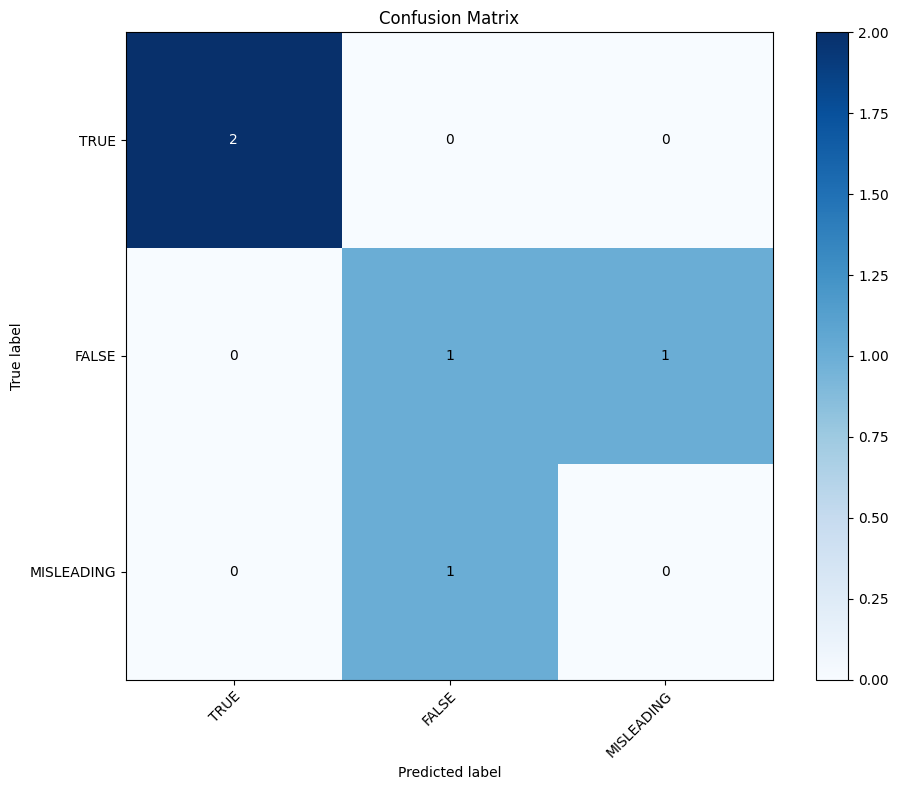

<Figure size 1000x800 with 0 Axes>

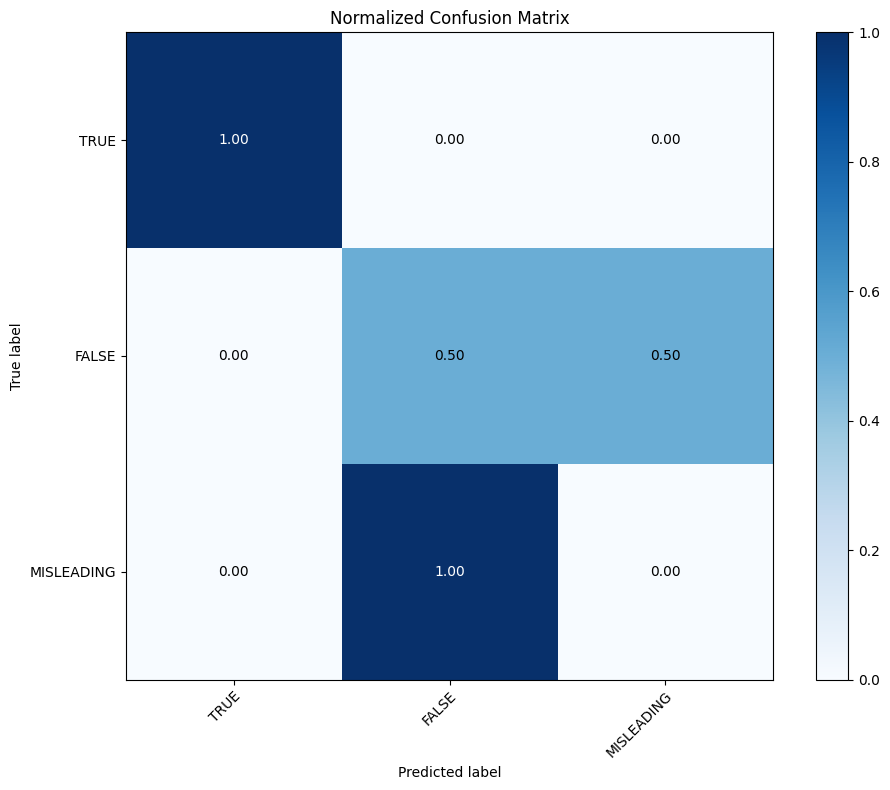

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_performance(y_true, y_pred, labels=None):
    """
    Generate and plot confusion matrix and other evaluation metrics

    Parameters:
    y_true (list): List of true labels
    y_pred (list): List of predicted labels
    labels (list): Optional list of label names

    Returns:
    dict: Dictionary containing evaluation metrics
    """
    if labels is None:
        labels = ["TRUE", "FALSE", "MISLEADING"]

    # Convert string labels to numeric if needed
    label_map = {
        "TRUE": 0, "True": 0, "real": 0, True: 0,
        "FALSE": 1, "False": 1, "fake": 1, False: 1,
        "MISLEADING": 2, "Misleading": 2, "misleading": 2
    }

    # Convert labels if they're strings
    if isinstance(y_true[0], str):
        y_true_numeric = [label_map.get(label, label) for label in y_true]
    else:
        y_true_numeric = y_true

    if isinstance(y_pred[0], str):
        y_pred_numeric = [label_map.get(label, label) for label in y_pred]
    else:
        y_pred_numeric = y_pred

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_numeric, y_pred_numeric)

    # Calculate metrics
    accuracy = accuracy_score(y_true_numeric, y_pred_numeric)
    precision = precision_score(y_true_numeric, y_pred_numeric, average='weighted')
    recall = recall_score(y_true_numeric, y_pred_numeric, average='weighted')
    f1 = f1_score(y_true_numeric, y_pred_numeric, average='weighted')

    # Generate detailed classification report
    report = classification_report(y_true_numeric, y_pred_numeric, target_names=labels)

    # Return metrics as dictionary
    metrics = {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'report': report
    }

    return metrics

def plot_confusion_matrix(cm, class_names=None, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot confusion matrix with options for normalization

    Parameters:
    cm (array): Confusion matrix array from sklearn
    class_names (list): List of class names
    normalize (bool): Whether to normalize the confusion matrix
    title (str): Title for the plot
    cmap: Colormap for the plot

    Returns:
    matplotlib.figure: The figure with the confusion matrix plot
    """
    if class_names is None:
        class_names = ["TRUE", "FALSE", "MISLEADING"]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = f'Normalized {title}'
    else:
        fmt = 'd'

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Set labels, title, and ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return fig

y_true = ["TRUE", "FALSE", "MISLEADING", "TRUE", "FALSE"]
y_pred = ["TRUE", "FALSE", "FALSE", "TRUE", "MISLEADING"]

# Get metrics
metrics = evaluate_model_performance(y_true, y_pred)

# Print metrics
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print("\nClassification Report:")
print(metrics['report'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
fig = plot_confusion_matrix(metrics['confusion_matrix'])
plt.savefig('confusion_matrix.png')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
fig = plot_confusion_matrix(metrics['confusion_matrix'], normalize=True)
plt.savefig('normalized_confusion_matrix.png')

In [19]:
!pip install Gradio

In [17]:
import gradio as gr
import os

# Gradio callback function
def gradio_misinformation_detector(claim_text):
    global detector
    if 'detector' not in globals() or detector is None:
        try:
            global config
            model_save_directory = os.path.join(config.output_dir, "finetune/best_model")
            detector = MedicalMisinformationDetector(model_save_directory)
        except Exception as e:
            return f"Error: Could not initialize the detector. Exception:\n{e}"

    try:
        detection_result = detector.detect_misinformation(claim_text)
        explanation_text = detector.get_explanation(claim_text, detection_result)

        model_conf = detection_result.get('model_confidence')
        trust_score = detection_result.get('trust_score')
        combined_score = detection_result.get('combined_score')

        result = f"**Claim:** {claim_text}\n\n"
        result += f"**Classification:** {detection_result.get('label', 'N/A')}\n"
        if trust_score is not None:
            result += f"**Trust Score (RAG):** {int(trust_score)}\n"
        if combined_score is not None:
            result += f"**Combined Score:** {combined_score:.2f}\n"
        if detection_result.get("rag_error"):
            result += f"**RAG Status:** {detection_result['rag_error']}\n"
        result += f"\n**Explanation:**\n{explanation_text}"

        return result

    except Exception as e:
        import traceback
        return f"Error during processing:\n{traceback.format_exc()}"

# Launch the Gradio interface
gr.Interface(
    fn=gradio_misinformation_detector,
    inputs=gr.Textbox(label="Enter Medical Claim Here", lines=5),
    outputs=gr.Textbox(label="Detection Result", interactive=False, lines=15),
    title="Medical Misinformation Detector",
    description="Paste a medical claim or statement to get its classification (TRUE, FALSE, or MISLEADING), confidence scores, and an explanation based on medical literature search (RAG)."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b5f097e07cc2fef464.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_performance(y_true, y_pred, labels=None):
    """
    Generate and plot confusion matrix and other evaluation metrics

    Parameters:
    y_true (list): List of true labels
    y_pred (list): List of predicted labels
    labels (list): Optional list of label names

    Returns:
    dict: Dictionary containing evaluation metrics
    """
    # Use default labels if none provided
    if labels is None:
        labels = ["TRUE", "FALSE", "MISLEADING"]

    # Convert string labels to numeric if needed using the defined label_map
    label_map = {
        "TRUE": 0, "True": 0, "real": 0, True: 0,
        "FALSE": 1, "False": 1, "fake": 1, False: 1,
        "MISLEADING": 2, "Misleading": 2, "misleading": 2
    }

    # Convert labels to numeric
    y_true_numeric = [label_map.get(str(label).upper(), None) for label in y_true]
    y_pred_numeric = [label_map.get(str(label).upper(), None) for label in y_pred]

    # Filter out entries where label mapping failed
    combined = list(zip(y_true_numeric, y_pred_numeric))
    filtered_combined = [(yt, yp) for yt, yp in combined if yt is not None and yp is not None]

    if not filtered_combined:
        print("Warning: No valid labels left after mapping. Cannot compute metrics.")
        return None
    y_true_numeric, y_pred_numeric = zip(*filtered_combined)

    # Identify unique numeric labels present in the data
    unique_numeric_labels_present = sorted(list(set(y_true_numeric) | set(y_pred_numeric)))

    # Define all possible numeric labels based on the label_map values
    all_possible_numeric_labels = sorted(list(set(label_map.values())))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_numeric, y_pred_numeric, labels=all_possible_numeric_labels)

    # Calculate metrics - use the set of all possible labels for precision/recall/f1
    accuracy = accuracy_score(y_true_numeric, y_pred_numeric)

    # Handle potential ZeroDivisionError if a class is missing entirely in true labels
    precision = precision_score(y_true_numeric, y_pred_numeric, labels=all_possible_numeric_labels, average='weighted', zero_division='warn')
    recall = recall_score(y_true_numeric, y_pred_numeric, labels=all_possible_numeric_labels, average='weighted', zero_division='warn')
    f1 = f1_score(y_true_numeric, y_pred_numeric, labels=all_possible_numeric_labels, average='weighted', zero_division='warn')


    # Generate detailed classification report
    report = classification_report(
        y_true_numeric,
        y_pred_numeric,
        labels=all_possible_numeric_labels,
        target_names=labels,
        zero_division='warn'
    )

    # Return metrics as dictionary
    metrics = {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'report': report
    }

    return metrics

# The plot_confusion_matrix function remains the same as it already takes the cm and class_names

def plot_confusion_matrix(cm, class_names=None, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot confusion matrix with options for normalization

    Parameters:
    cm (array): Confusion matrix array from sklearn
    class_names (list): List of class names
    normalize (bool): Whether to normalize the confusion matrix
    title (str): Title for the plot
    cmap: Colormap for the plot

    Returns:
    matplotlib.figure: The figure with the confusion matrix plot
    """
    if class_names is None:
        class_names = ["TRUE", "FALSE", "MISLEADING"]

    # Check if confusion matrix is None or empty
    if cm is None or cm.size == 0:
        print("Cannot plot confusion matrix: No data or invalid matrix.")
        return None


    if normalize:
        cm_normalized = cm.astype('float')
        row_sums = cm_normalized.sum(axis=1)
        row_sums[row_sums == 0] = 1e-9
        cm_normalized = cm_normalized / row_sums[:, np.newaxis]
        cm_display = cm_normalized
        fmt = '.2f'
        title = f'Normalized {title}'
    else:
        cm_display = cm
        fmt = 'd'


    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_display, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Set labels, title, and ticks
    # Ensure the ticks match the dimensions of the confusion matrix
    ax.set(xticks=np.arange(cm_display.shape[1]),
           yticks=np.arange(cm_display.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm_display.max() / 2.
    for i in range(cm_display.shape[0]):
        for j in range(cm_display.shape[1]):
            cell_value = cm_display[i, j]
            if np.isnan(cell_value) or np.isinf(cell_value):
                 text_to_display = "N/A"
            else:
                 text_to_display = format(cell_value, fmt)

            ax.text(j, i, text_to_display,
                    ha="center", va="center",
                    color="white" if cm_display[i, j] > thresh else "black")

    fig.tight_layout()
    return fig

Evaluating: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


--- Evaluation Metrics ---
Accuracy: 0.3200
Weighted F1 Score: 0.1552

--- Classification Report ---
              precision    recall  f1-score   support

       FALSE       0.32      1.00      0.48        32
  MISLEADING       0.00      0.00      0.00        14
        TRUE       0.00      0.00      0.00        54

    accuracy                           0.32       100
   macro avg       0.11      0.33      0.16       100
weighted avg       0.10      0.32      0.16       100



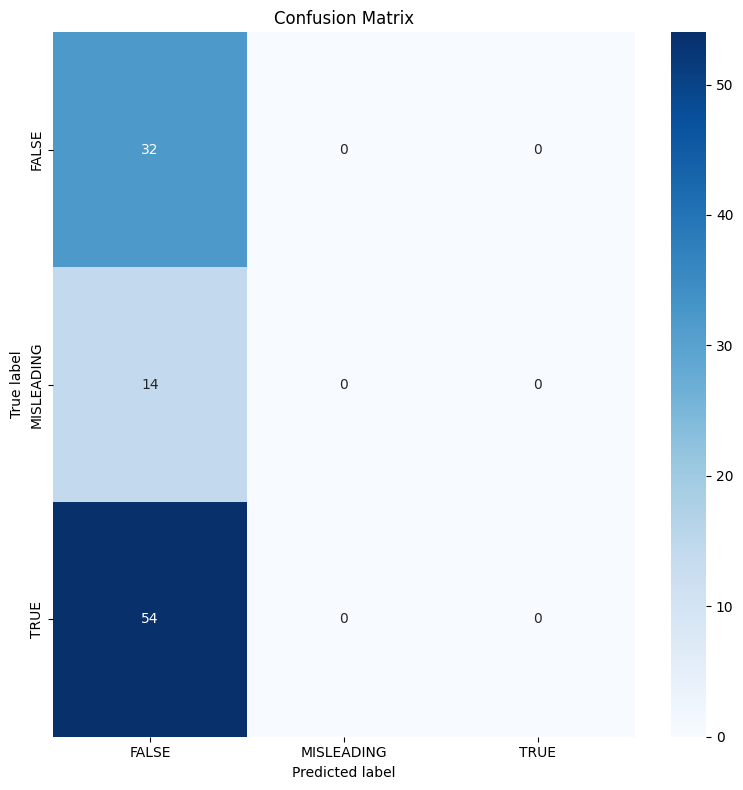

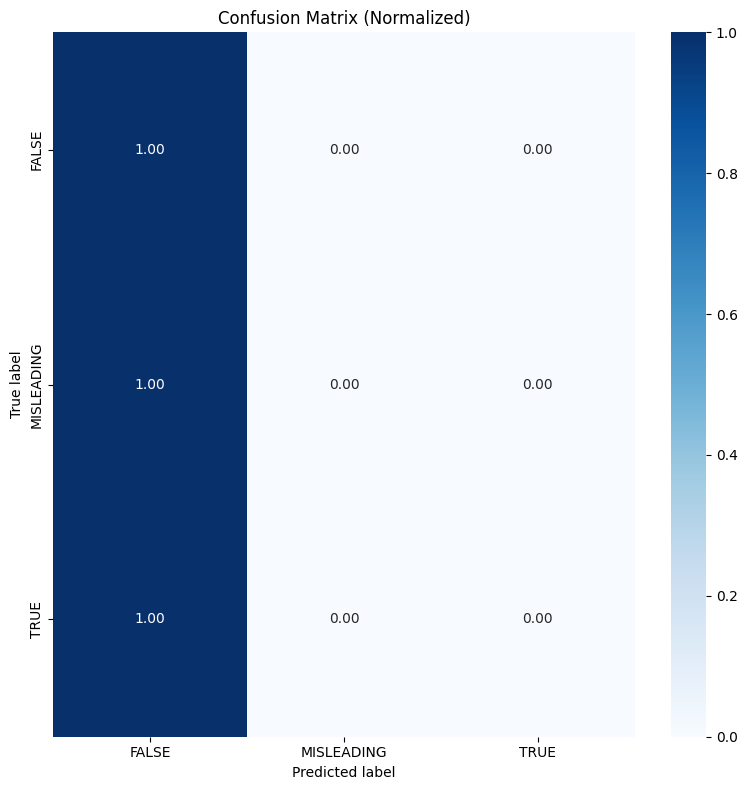

In [22]:
import json
import os
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# --- Configuration ---
benchmark_file_path = "/content/drive/MyDrive/benchmark_100_samples.json"
model_save_directory = "/content/drive/MyDrive/Model/finetune/best_model"

def evaluate_model_performance(y_true, y_pred, labels):
    try:
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        report = classification_report(y_true, y_pred, labels=labels, zero_division='warn')
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        return {
            "accuracy": acc,
            "f1_score": f1,
            "report": report,
            "confusion_matrix": cm
        }
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return None

def plot_confusion_matrix(cm, class_names, normalize=False):
    if cm is None or cm.size == 0:
        print("Cannot plot confusion matrix: No data or invalid matrix.")
        return None

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.tight_layout()
    return fig

benchmark_data = []
try:
    with open(benchmark_file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    benchmark_data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Skipping invalid JSON: {line[:100]}... Error: {e}")
except FileNotFoundError:
    print(f"Error: Benchmark file not found at {benchmark_file_path}")
except Exception as e:
    print(f"Failed to load benchmark file: {e}")

if not benchmark_data:
    print("No valid benchmark data found.")
else:
    y_true = []
    y_pred = []

    # Label normalization map (all keys lowercase strings)
    label_map = {
        "true": "TRUE",
        "false": "FALSE",
        "misleading": "MISLEADING",
        "real": "TRUE",
        "fake": "FALSE",
        "0": "TRUE",
        "1": "FALSE",
        "2": "MISLEADING"
    }

    for entry in tqdm(benchmark_data, desc="Evaluating"):
        claim = entry.get("claim")
        raw_label = entry.get("label")

        if claim is None or raw_label is None:
            print(f"Skipping entry due to missing 'claim' or label: {entry}")
            continue

        normalized_label = str(raw_label).strip().lower()
        true_label_str = label_map.get(normalized_label, None)

        if true_label_str is None:
            print(f"Warning: Skipping entry with unknown true label: {raw_label}")
            continue

        try:
            detection_result = detector.detect_misinformation(claim, include_confidence=False)
            predicted_label_str = detection_result.get("label")

            if predicted_label_str is None or predicted_label_str not in label_map.values():
                print(f"Warning: Detector returned unknown predicted label: {predicted_label_str}")
                continue

            y_true.append(true_label_str)
            y_pred.append(predicted_label_str)

        except Exception as e:
            print(f"Error predicting claim '{claim[:50]}...': {e}")
            continue

    if not y_true:
        print("No valid predictions were made for evaluation.")
    else:
        all_labels_in_data = sorted(list(set(y_true) | set(y_pred)))

        metrics = evaluate_model_performance(y_true, y_pred, labels=all_labels_in_data)

        if metrics:
            print("\n--- Evaluation Metrics ---")
            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Weighted F1 Score: {metrics['f1_score']:.4f}")

            print("\n--- Classification Report ---")
            print(metrics['report'])

            plot_confusion_matrix(metrics['confusion_matrix'], class_names=all_labels_in_data, normalize=False)
            plt.show()

            plot_confusion_matrix(metrics['confusion_matrix'], class_names=all_labels_in_data, normalize=True)
            plt.show()
